In [1]:
import gc

import pandas as pd
import numpy as np
from IPython.display import display, Markdown
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score

In [2]:
%matplotlib inline

In [3]:

bureau_raw = pd.read_csv('home-credit-default-risk/bureau.csv')
bureau_bal_raw = pd.read_csv('home-credit-default-risk/bureau_balance.csv')
credit_bal_raw = pd.read_csv('home-credit-default-risk/credit_card_balance.csv')
install_raw = pd.read_csv('home-credit-default-risk/installments_payments.csv')
pos_raw = pd.read_csv('home-credit-default-risk/POS_CASH_balance.csv')
prev_appl_raw = pd.read_csv('home-credit-default-risk/previous_application.csv')

In [4]:
buro_counts = bureau_bal_raw[['SK_ID_BUREAU', 'MONTHS_BALANCE']].groupby('SK_ID_BUREAU').count()
bureau_bal_raw['buro_count'] = bureau_bal_raw['SK_ID_BUREAU'].map(buro_counts['MONTHS_BALANCE'])
avg_buro_bal = bureau_bal_raw.groupby('SK_ID_BUREAU').mean()
avg_buro_bal.columns = ['avg_buro_' + f_ for f_ in avg_buro_bal.columns]

del bureau_bal_raw
gc.collect()

21

In [5]:
buro_full = bureau_raw.merge(right=avg_buro_bal.reset_index(), how='left', on='SK_ID_BUREAU', suffixes=('', '_bur_bal'))
nb_bureau_per_curr = buro_full[['SK_ID_CURR', 'SK_ID_BUREAU']].groupby('SK_ID_CURR').count()
buro_full['SK_ID_BUREAU'] = buro_full['SK_ID_CURR'].map(nb_bureau_per_curr['SK_ID_BUREAU'])
avg_buro = buro_full.groupby('SK_ID_CURR').mean()

del bureau_raw
gc.collect()

7

In [6]:
prev_cat_features = [f_ for f_ in prev_appl_raw.columns if prev_appl_raw[f_].dtype == 'object']
nb_prev_per_curr = prev_appl_raw[['SK_ID_CURR', 'SK_ID_PREV']].groupby('SK_ID_CURR').count()
prev_appl_raw['SK_ID_PREV'] = prev_appl_raw['SK_ID_CURR'].map(nb_prev_per_curr['SK_ID_PREV'])
avg_prev = prev_appl_raw.groupby('SK_ID_CURR').mean()

del prev_appl_raw
gc.collect()

14

In [7]:
nb_prevs = pos_raw[['SK_ID_CURR', 'SK_ID_PREV']].groupby('SK_ID_CURR').count()
pos_raw['SK_ID_PREV'] = pos_raw['SK_ID_CURR'].map(nb_prevs['SK_ID_PREV'])
avg_pos = pos_raw.groupby('SK_ID_CURR').mean()

del pos_raw
gc.collect()

14

In [8]:
nb_prevs = credit_bal_raw[['SK_ID_CURR', 'SK_ID_PREV']].groupby('SK_ID_CURR').count()
credit_bal_raw['SK_ID_PREV'] = credit_bal_raw['SK_ID_CURR'].map(nb_prevs['SK_ID_PREV'])
avg_cc_bal = credit_bal_raw.groupby('SK_ID_CURR').mean()
avg_cc_bal.columns = ['cc_bal_' + f_ for f_ in avg_cc_bal.columns]

del credit_bal_raw, nb_prevs
gc.collect()

42

In [9]:
nb_prevs = install_raw[['SK_ID_CURR', 'SK_ID_PREV']].groupby('SK_ID_CURR').count()
install_raw['SK_ID_PREV'] = install_raw['SK_ID_CURR'].map(nb_prevs['SK_ID_PREV'])
avg_inst = install_raw.groupby('SK_ID_CURR').mean()
avg_inst.columns = ['inst_' + f_ for f_ in avg_inst.columns]

In [10]:
data = pd.read_csv('home-credit-default-risk/application_train.csv')
test = pd.read_csv('home-credit-default-risk/application_test.csv')

In [11]:
data.shape, test.shape

((307511, 122), (48744, 121))

In [12]:
data = data.merge(right=avg_buro.reset_index(), how='left', on='SK_ID_CURR')
test = test.merge(right=avg_buro.reset_index(), how='left', on='SK_ID_CURR')

data = data.merge(right=avg_prev.reset_index(), how='left', on='SK_ID_CURR')
test = test.merge(right=avg_prev.reset_index(), how='left', on='SK_ID_CURR')

data = data.merge(right=avg_pos.reset_index(), how='left', on='SK_ID_CURR')
test = test.merge(right=avg_pos.reset_index(), how='left', on='SK_ID_CURR')

data = data.merge(right=avg_cc_bal.reset_index(), how='left', on='SK_ID_CURR')
test = test.merge(right=avg_cc_bal.reset_index(), how='left', on='SK_ID_CURR')

data = data.merge(right=avg_inst.reset_index(), how='left', on='SK_ID_CURR')
test = test.merge(right=avg_inst.reset_index(), how='left', on='SK_ID_CURR')

del avg_buro, avg_prev
gc.collect()

126

In [13]:
data.shape, test.shape

((307511, 191), (48744, 190))

In [14]:
X_train, y_train = data.iloc[:,2:], data.TARGET
X_test = test.iloc[:,1:]

In [15]:
col_vals_dict = {c: list(X_train[c].unique()) for c in X_train.columns if X_train[c].dtype == object}
col_vals_dict

{'NAME_CONTRACT_TYPE': ['Cash loans', 'Revolving loans'],
 'CODE_GENDER': ['M', 'F', 'XNA'],
 'FLAG_OWN_CAR': ['N', 'Y'],
 'FLAG_OWN_REALTY': ['Y', 'N'],
 'NAME_TYPE_SUITE': ['Unaccompanied',
  'Family',
  'Spouse, partner',
  'Children',
  'Other_A',
  nan,
  'Other_B',
  'Group of people'],
 'NAME_INCOME_TYPE': ['Working',
  'State servant',
  'Commercial associate',
  'Pensioner',
  'Unemployed',
  'Student',
  'Businessman',
  'Maternity leave'],
 'NAME_EDUCATION_TYPE': ['Secondary / secondary special',
  'Higher education',
  'Incomplete higher',
  'Lower secondary',
  'Academic degree'],
 'NAME_FAMILY_STATUS': ['Single / not married',
  'Married',
  'Civil marriage',
  'Widow',
  'Separated',
  'Unknown'],
 'NAME_HOUSING_TYPE': ['House / apartment',
  'Rented apartment',
  'With parents',
  'Municipal apartment',
  'Office apartment',
  'Co-op apartment'],
 'OCCUPATION_TYPE': ['Laborers',
  'Core staff',
  'Accountants',
  'Managers',
  nan,
  'Drivers',
  'Sales staff',
  'Clean

In [16]:
nb_numeric   = len(X_train.columns) - len(col_vals_dict)
nb_categoric = len(col_vals_dict)
print('Number of Numerical features:', nb_numeric)
print('Number of Categorical features:', nb_categoric)

Number of Numerical features: 173
Number of Categorical features: 16


In [17]:
# Store the labels of each features
col_vals_dict = {c: list(X_train[c].unique()) for c in X_train.columns if X_train[c].dtype == object}

In [18]:
col_vals_dict

{'NAME_CONTRACT_TYPE': ['Cash loans', 'Revolving loans'],
 'CODE_GENDER': ['M', 'F', 'XNA'],
 'FLAG_OWN_CAR': ['N', 'Y'],
 'FLAG_OWN_REALTY': ['Y', 'N'],
 'NAME_TYPE_SUITE': ['Unaccompanied',
  'Family',
  'Spouse, partner',
  'Children',
  'Other_A',
  nan,
  'Other_B',
  'Group of people'],
 'NAME_INCOME_TYPE': ['Working',
  'State servant',
  'Commercial associate',
  'Pensioner',
  'Unemployed',
  'Student',
  'Businessman',
  'Maternity leave'],
 'NAME_EDUCATION_TYPE': ['Secondary / secondary special',
  'Higher education',
  'Incomplete higher',
  'Lower secondary',
  'Academic degree'],
 'NAME_FAMILY_STATUS': ['Single / not married',
  'Married',
  'Civil marriage',
  'Widow',
  'Separated',
  'Unknown'],
 'NAME_HOUSING_TYPE': ['House / apartment',
  'Rented apartment',
  'With parents',
  'Municipal apartment',
  'Office apartment',
  'Co-op apartment'],
 'OCCUPATION_TYPE': ['Laborers',
  'Core staff',
  'Accountants',
  'Managers',
  nan,
  'Drivers',
  'Sales staff',
  'Clean

In [19]:
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, precision_recall_curve, roc_curve, average_precision_score
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, merge, Reshape, Dropout, Input, Flatten, Concatenate
from keras.layers.embeddings import Embedding
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


In [20]:
# Generator to parse the cat
generator = (c for c in X_train.columns if X_train[c].dtype == object)

# Label Encoder
for c in generator:
    lbl = LabelEncoder()
    lbl.fit(list(X_train[c].values) + list(X_test[c].values))
    X_train[c] = lbl.transform(list(X_train[c].values))
    X_test[c] = lbl.transform(list(X_test[c].values))

In [21]:
embed_cols = []
len_embed_cols = []
for c in col_vals_dict:
    if len(col_vals_dict[c])>2:
        embed_cols.append(c)
        len_embed_cols.append(len(col_vals_dict[c]))
        print(c + ': %d values' % len(col_vals_dict[c]))
print('\n Number of embed features :', len(embed_cols))

CODE_GENDER: 3 values
NAME_TYPE_SUITE: 8 values
NAME_INCOME_TYPE: 8 values
NAME_EDUCATION_TYPE: 5 values
NAME_FAMILY_STATUS: 6 values
NAME_HOUSING_TYPE: 6 values
OCCUPATION_TYPE: 19 values
WEEKDAY_APPR_PROCESS_START: 7 values
ORGANIZATION_TYPE: 58 values
FONDKAPREMONT_MODE: 5 values
HOUSETYPE_MODE: 4 values
WALLSMATERIAL_MODE: 8 values
EMERGENCYSTATE_MODE: 3 values

 Number of embed features : 13


In [22]:
def build_embedding_network(len_embed_cols):
    
    model_out = []
    model_in  = []
    
    for dim in len_embed_cols:
        input_dim = Input(shape=(1,), dtype='int32')
        embed_dim = Embedding(dim, dim//2, input_length=1)(input_dim)
        embed_dim = Dropout(0.25)(embed_dim)
        embed_dim = Reshape((dim//2,))(embed_dim)
        model_out.append(embed_dim)
        model_in.append(input_dim)
    
    input_num = Input(shape=(176,), dtype='float32')
    outputs = Concatenate(axis=1)([*model_out, input_num])
    
    outputs = (Dense(128))(outputs) 
    outputs = (Activation('relu'))(outputs)
    outputs = (Dropout(.35))(outputs)
    outputs = (Dense(64))(outputs)
    outputs = (Activation('relu'))(outputs)
    outputs = (Dropout(.15))(outputs)
    outputs = (Dense(32))(outputs) 
    outputs = (Activation('relu'))(outputs)
    outputs = (Dropout(.15))(outputs)
    outputs = (Dense(1))(outputs)
    outputs = (Activation('sigmoid'))(outputs)
    
    model = Model([*model_in, input_num], outputs)

    model.compile(loss='binary_crossentropy', optimizer='adam')
    
    return model

In [23]:
def preproc(X_train, X_val, X_test):

    input_list_train = []
    input_list_val = []
    input_list_test = []
    
    #the cols to be embedded: rescaling to range [0, # values)
    for c in embed_cols:
        raw_vals = np.unique(X_train[c])
        val_map = {}
        for i in range(len(raw_vals)):
            val_map[raw_vals[i]] = i
        gc.collect()
        input_list_train.append(X_train[c].map(val_map).values)
        input_list_val.append(X_val[c].map(val_map).fillna(0).values)
        input_list_test.append(X_test[c].map(val_map).fillna(0).values)
        
    #the rest of the columns
    other_cols = [c for c in X_train.columns if (not c in embed_cols)]
    input_list_train.append(X_train[other_cols].values)
    input_list_val.append(X_val[other_cols].values)
    input_list_test.append(X_test[other_cols].values)
    
    return input_list_train, input_list_val, input_list_test

In [24]:
proc_X_train_f, proc_X_val_f, proc_X_test_f = preproc(X_train, X_train, X_test)
print('Length of the list:', len(proc_X_train_f))

Length of the list: 14


In [25]:
gc.collect()

21

In [26]:
# Select the numeric features
num_cols = [x for x in X_train.columns if x not in embed_cols]


# Impute missing values in order to scale
X_train[num_cols] = X_train[num_cols].fillna(value = 0)
X_test[num_cols] = X_test[num_cols].fillna(value = 0)



# Fit the scaler only on train data
scaler = MinMaxScaler().fit(X_train[num_cols])
X_train.loc[:,num_cols] = scaler.transform(X_train[num_cols])
X_test.loc[:,num_cols] = scaler.transform(X_test[num_cols])

In [36]:
X_train[0]

Train on 246008 samples, validate on 61503 samples
Epoch 1/250
246008/246008 [==============================] - 7s 30us/step - loss: 0.3169 - val_loss: 0.2683
Epoch 2/250
246008/246008 [==============================] - 5s 22us/step - loss: 0.2734 - val_loss: 0.2572
Epoch 3/250
246008/246008 [==============================] - 5s 21us/step - loss: 0.2648 - val_loss: 0.2552
Epoch 4/250
246008/246008 [==============================] - 5s 22us/step - loss: 0.2611 - val_loss: 0.2530
Epoch 5/250
246008/246008 [==============================] - 6s 23us/step - loss: 0.2598 - val_loss: 0.2524
Epoch 6/250
246008/246008 [==============================] - 6s 23us/step - loss: 0.2585 - val_loss: 0.2519
Epoch 7/250
246008/246008 [==============================] - 5s 21us/step - loss: 0.2569 - val_loss: 0.2517
Epoch 8/250
246008/246008 [==============================] - 6s 23us/step - loss: 0.2565 - val_loss: 0.2516
Epoch 9/250
246008/246008 [==============================] - 5s 22us/step - loss: 0.2

246009/246009 [==============================] - 5s 19us/step - loss: 0.2469 - val_loss: 0.2483
Epoch 35/250
246009/246009 [==============================] - 5s 19us/step - loss: 0.2466 - val_loss: 0.2483
Epoch 36/250
246009/246009 [==============================] - 5s 19us/step - loss: 0.2468 - val_loss: 0.2486
Epoch 37/250
246009/246009 [==============================] - 5s 19us/step - loss: 0.2465 - val_loss: 0.2482
Epoch 38/250
246009/246009 [==============================] - 5s 19us/step - loss: 0.2456 - val_loss: 0.2481
Epoch 39/250
246009/246009 [==============================] - 5s 20us/step - loss: 0.2451 - val_loss: 0.2483
Epoch 40/250
246009/246009 [==============================] - 5s 19us/step - loss: 0.2453 - val_loss: 0.2483
Epoch 41/250
246009/246009 [==============================] - 5s 19us/step - loss: 0.2447 - val_loss: 0.2477
Epoch 42/250
246009/246009 [==============================] - 5s 19us/step - loss: 0.2450 - val_loss: 0.2480
Epoch 43/250
246009/246009 [====

Epoch 12/250
246009/246009 [==============================] - 5s 20us/step - loss: 0.2538 - val_loss: 0.2506
Epoch 13/250
246009/246009 [==============================] - 5s 20us/step - loss: 0.2532 - val_loss: 0.2496
Epoch 14/250
246009/246009 [==============================] - 5s 20us/step - loss: 0.2526 - val_loss: 0.2494
Epoch 15/250
246009/246009 [==============================] - 5s 20us/step - loss: 0.2520 - val_loss: 0.2496
Epoch 16/250
246009/246009 [==============================] - 5s 20us/step - loss: 0.2519 - val_loss: 0.2494
Epoch 17/250
246009/246009 [==============================] - 6s 24us/step - loss: 0.2520 - val_loss: 0.2489
Epoch 18/250
246009/246009 [==============================] - 6s 23us/step - loss: 0.2510 - val_loss: 0.2489
Epoch 19/250
246009/246009 [==============================] - 5s 21us/step - loss: 0.2504 - val_loss: 0.2488
Epoch 20/250
246009/246009 [==============================] - 6s 25us/step - loss: 0.2502 - val_loss: 0.2484
Epoch 21/250
246009

In [32]:
def display_roc_curve(y_, oof_preds_, folds_idx_):
    # Plot ROC curves
    plt.figure(figsize=(6,6))
    scores = [] 
    for n_fold, (_, val_idx) in enumerate(folds_idx_):  
        # Plot the roc curve
        fpr, tpr, thresholds = roc_curve(y_.iloc[val_idx], oof_preds_[val_idx])
        score = roc_auc_score(y_.iloc[val_idx], oof_preds_[val_idx])
        scores.append(score)
        plt.plot(fpr, tpr, lw=1, alpha=0.3, label='ROC fold %d (AUC = %0.4f)' % (n_fold + 1, score))
    
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Luck', alpha=.8)
    fpr, tpr, thresholds = roc_curve(y_, oof_preds_)
    score = roc_auc_score(y_, oof_preds_)
    plt.plot(fpr, tpr, color='b',
             label='Avg ROC (AUC = %0.4f $\pm$ %0.4f)' % (score, np.std(scores)),
             lw=2, alpha=.8)
    
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Embedding Neural Network ROC Curve')
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()
    
def display_precision_recall(y_, oof_preds_, folds_idx_):
    # Plot ROC curves
    plt.figure(figsize=(6,6))
    
    scores = [] 
    for n_fold, (_, val_idx) in enumerate(folds_idx_):  
        # Plot the roc curve
        fpr, tpr, thresholds = roc_curve(y_.iloc[val_idx], oof_preds_[val_idx])
        score = average_precision_score(y_.iloc[val_idx], oof_preds_[val_idx])
        scores.append(score)
        plt.plot(fpr, tpr, lw=1, alpha=0.3, label='AP fold %d (AUC = %0.4f)' % (n_fold + 1, score))
    
    precision, recall, thresholds = precision_recall_curve(y_, oof_preds_)
    score = average_precision_score(y_, oof_preds_)
    plt.plot(precision, recall, color='b',
             label='Avg ROC (AUC = %0.4f $\pm$ %0.4f)' % (score, np.std(scores)),
             lw=2, alpha=.8)
    
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Embedding Neural Network Recall / Precision')
    plt.legend(loc="best")
    plt.tight_layout()
    
    plt.show()

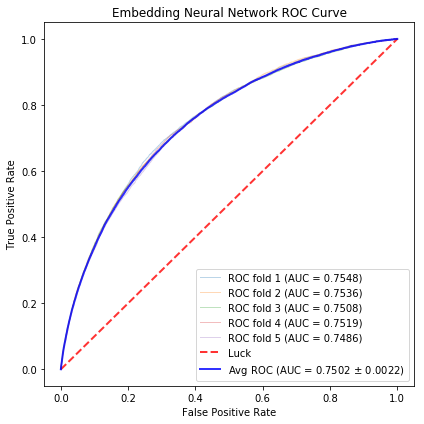

In [34]:
import matplotlib.pyplot as plt
folds_idx = [(trn_idx, val_idx) for trn_idx, val_idx in kfold.split(X_train, y_train)]
display_roc_curve(y_=y_train, oof_preds_=full_val_preds, folds_idx_=folds_idx)

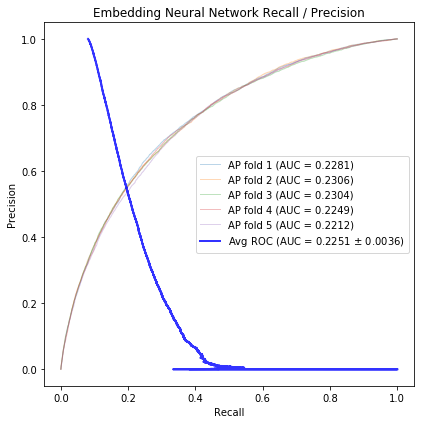

In [35]:
display_precision_recall(y_=y_train, oof_preds_=full_val_preds, folds_idx_=folds_idx)

In [ ]:
# test['TARGET'] = np.mean(y_preds, axis=1)
# test = test[['SK_ID_CURR', 'TARGET']]
# out_df = pd.DataFrame({'SK_ID_CURR': test['SK_ID_CURR'], 'TARGET': test['TARGET']})
# out_df.to_csv('nn_embedding_submission.csv', index=False)